In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("deep")
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from pmdarima.arima import ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from darts.models import AutoARIMA
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
GLOBAL_BLUE = "#4285F4"
GLOBAL_RED = "#DB4437"
GLOBAL_YELLOW = "#F4B400"
GLOBAL_GREEN = "#0F9D58"

def test_stationarity(col):
    testresult = ADFTest(alpha=0.05).should_diff(col)
    p, text = testresult[0], testresult[1]
    print('p-value: ' + str(round(p,2)))
    print('Ar reikia diferencijuoti: ' + str(text))

def plot_decomposition(col, period, timeframe):
    ts_dicomposition = seasonal_decompose(col, model='additive', period=period)
    trend_estimate = ts_dicomposition.trend
    seasonal_estimate = ts_dicomposition.seasonal
    residual_estimate = ts_dicomposition.resid

    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    # First plot to the Original time series
    axes[0].plot(col.XRP_price, label='Original', color = GLOBAL_BLUE, linewidth = 3) 
    axes[0].legend(loc='upper left');
    # second plot to be for trend
    axes[1].plot(trend_estimate, label='Trend', color = GLOBAL_RED, linewidth = 3)
    axes[1].legend(loc='upper left');
    # third plot to be Seasonality component
    axes[2].plot(seasonal_estimate, label='Seasonality', color = GLOBAL_YELLOW, linewidth = 3)
    axes[2].legend(loc='upper left');
    # last last plot to be Residual component
    axes[3].plot(residual_estimate, label='Residuals', color = GLOBAL_GREEN, linewidth = 3)
    axes[3].legend(loc='upper left');
    plt.savefig('images/' + timeframe + '_decomposition.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
    plt.savefig('images/' + timeframe + '_decomposition.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
    return trend_estimate, seasonal_estimate, residual_estimate

    
def plot_and_save_residuals(residuals, timeframe ):
    plt.figure(figsize=(7, 5))
    ax = sns.distplot(residuals, bins = 30)
    ax.set(xlabel='Residual', ylabel='Count')
    plt.axvline(residuals.mean(), c='k', ls='-', lw=2.5)
    plt.axvline(residuals.median(), c='orange', ls='--', lw=2.5)
    plt.savefig('images/' + timeframe + '_residuals_distribution.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
    plt.savefig('images/' + timeframe + '_residuals_distribution.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
    plt.show()

def test_normality(data):
    totest = data.copy()
    totest = totest.dropna()
    test, p = stats.shapiro(totest)
    print(p)
    print("P value: ", round(p, 3), " Statistic: ", round(test, 3))



def plot_and_do_forecast(filename, xlabel, title, timeframe):
    xrp = pd.read_csv(filename, parse_dates = ['time'])[['time','XRP_price']]
    series = TimeSeries.from_dataframe(xrp, 'time', 'XRP_price')
    split = int(xrp.shape[0]*0.7)
    train, val = series[:split], series[split:]
    
    model = AutoARIMA()
    model.fit(train)
    prediction = model.predict(len(val))
    
    fig, ax = plt.subplots(1, 1, figsize = (15, 5))
    series.plot(label='XRP kaina')
    prediction.plot(label='Prognozė', low_quantile=0.05, high_quantile=0.95)
    ax.set_title(title, fontsize=22)
    ax.set_ylabel('Kaina', fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.legend(prop={'size': 20})
    ax.grid()
    plt.legend()
    plt.savefig('images/' + timeframe + '_arima_results.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
    plt.savefig('images/' + timeframe + '_arima_results.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
    plt.show()
    pred = prediction.values().reshape(-1,)
    real = val.values().reshape(-1,)
    print("RMSE:",round(np.sqrt(mean_squared_error(real, pred)), 4))
    print("MAE:",round(mae(real, pred), 4))
    print("MAPE:",round(mean_absolute_percentage_error(real, pred), 4))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/mgaulia/miniforge3/envs/torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/mgaulia/miniforge3/envs/torch/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at11TensorMaker11make_tensorEv
  Referenced from: /Users/mgaulia/miniforge3/envs/torch/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Users/mgaulia/miniforge3/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
[2022-04-30 03:22:05,032] WARNING | darts.models | Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
2022-04-30 03:

# Day

In [86]:
day = pd.read_csv("data/full_day.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
test_stationarity(day.XRP_price)

p-value: 0.39
Ar reikia diferencijuoti: True


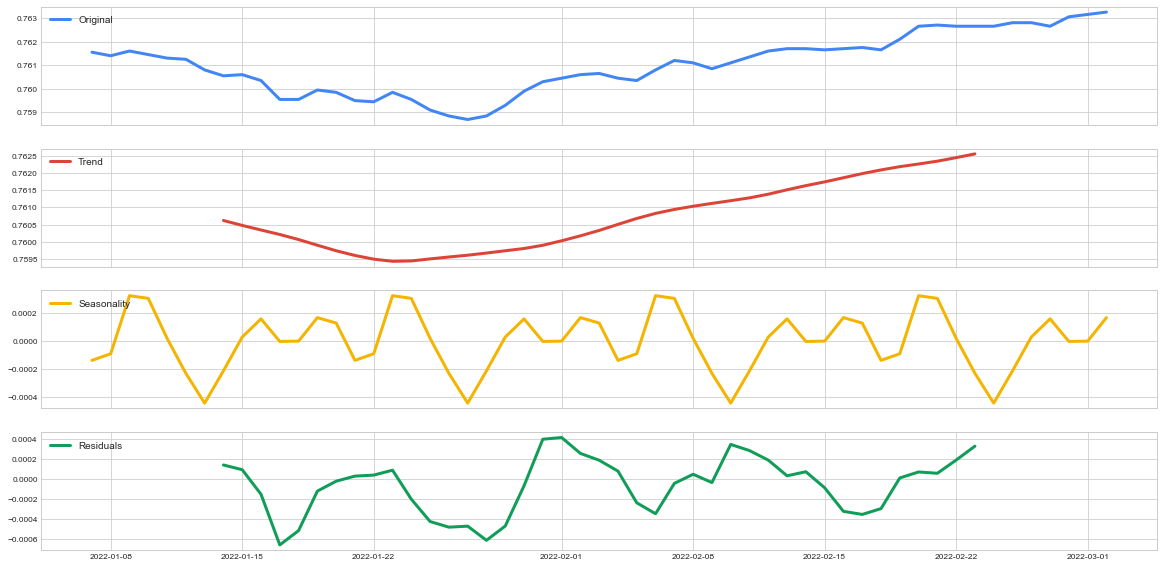

In [87]:
day_trend, day_seasonal, day_residuals = plot_decomposition(day, 14, "day")

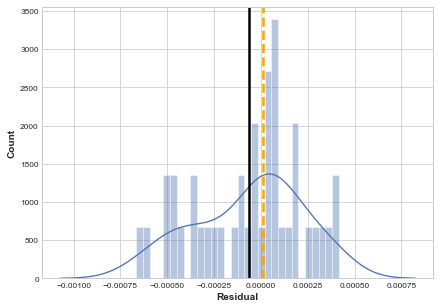

0.1643931120634079
P value:  0.164  Statistic:  0.961


In [88]:
plot_and_save_residuals(day_residuals, "day")
test_normality(day_residuals)

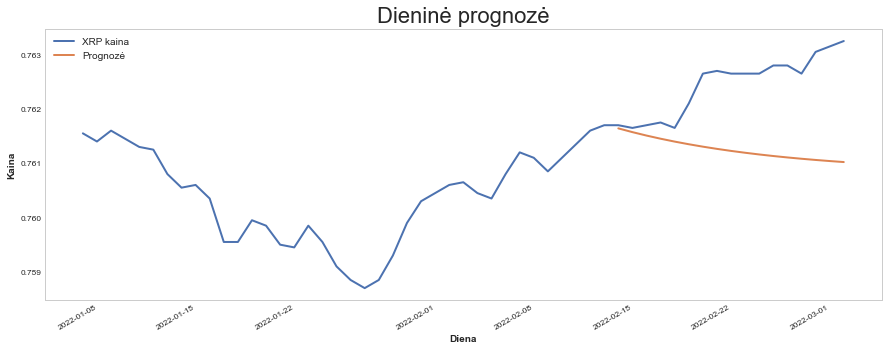

RMSE: 0.0014
MAE: 0.0012
MAPE: 0.0015


In [89]:
plot_and_do_forecast("data/full_day.csv", "Diena","Dieninė prognozė", "day")

# Hour

In [2]:
hour = pd.read_csv("data/full_hour.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
test_stationarity(hour.XRP_price)

p-value: 0.76
Ar reikia diferencijuoti: True


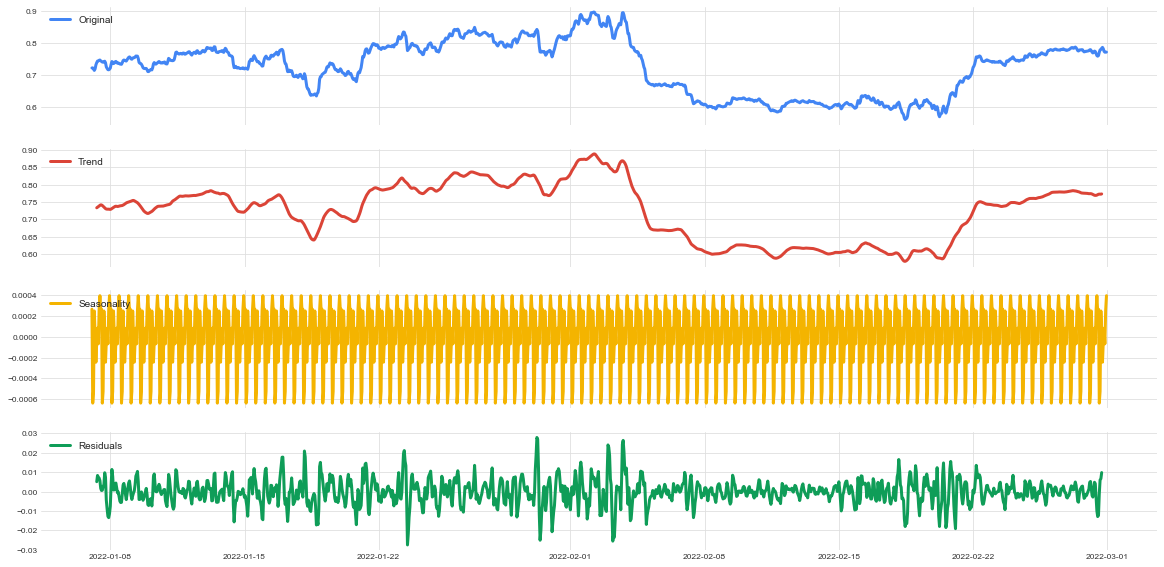

In [3]:
hour_trend, hour_seasonal, hour_residuals = plot_decomposition(hour, 12, "hour")

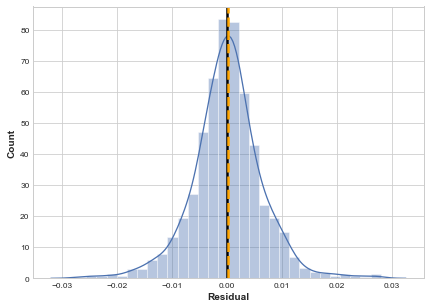

1.5229247509883533e-14
P value:  0.0  Statistic:  0.973


In [92]:
plot_and_save_residuals(hour_residuals, "hour")
test_normality(hour_residuals)

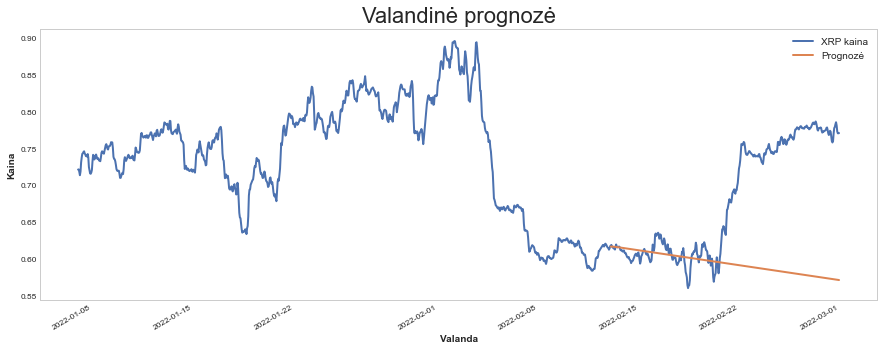

RMSE: 0.1223
MAE: 0.0897
MAPE: 0.1203


In [93]:
plot_and_do_forecast("data/full_hour.csv", "Valanda","Valandinė prognozė", "hour")

# Minute

In [94]:
minute = pd.read_csv("data/full_minute.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
test_stationarity(minute.XRP_price)

p-value: 0.75
Ar reikia diferencijuoti: True


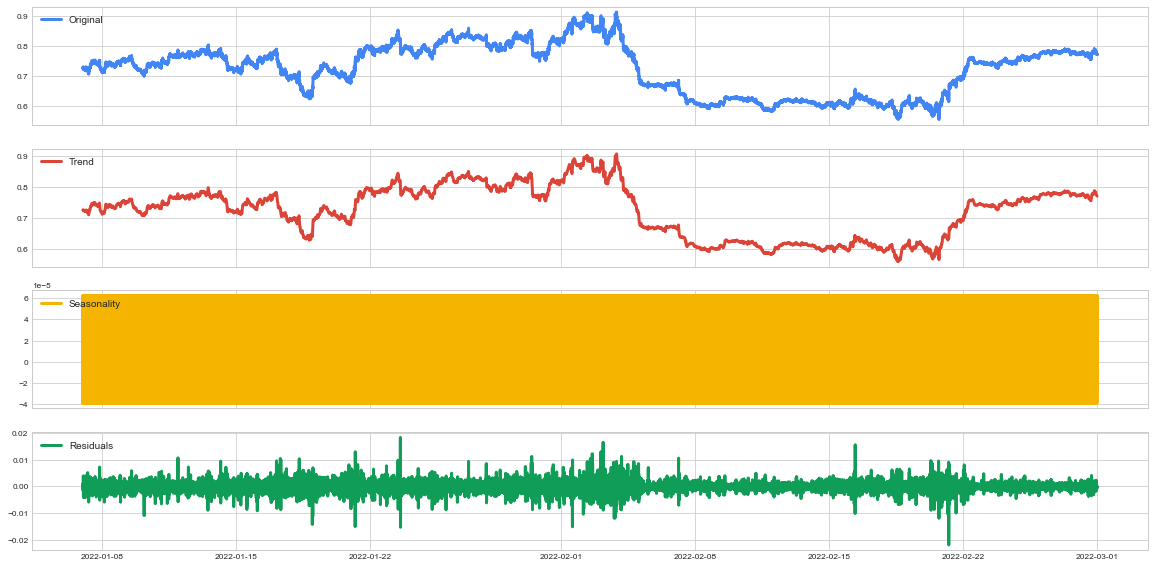

In [95]:
minute_trend, minute_seasonal, minute_residuals =  plot_decomposition(minute, 30, "minute")

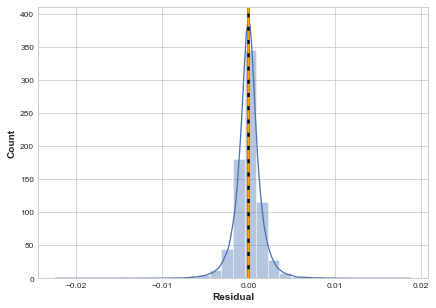

0.0
P value:  0.0  Statistic:  0.92


In [96]:
plot_and_save_residuals(minute_residuals, "minute")
test_normality(minute_residuals)

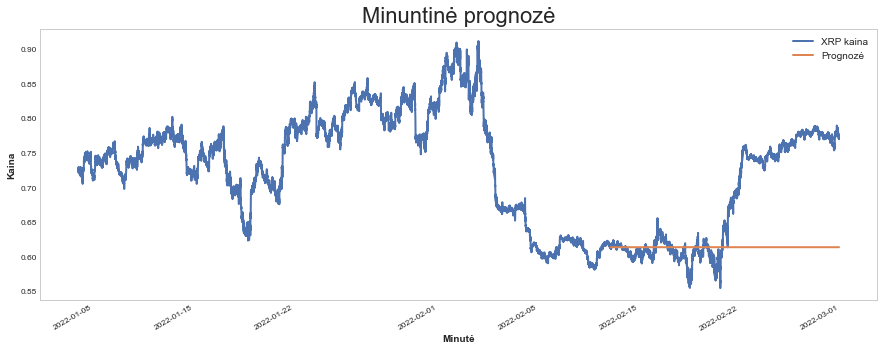

RMSE: 0.0998
MAE: 0.0741
MAPE: 0.1


In [97]:
plot_and_do_forecast("data/full_minute.csv", "Minutė","Minuntinė prognozė", "minute")
# Ilgai uztrunka, ieskoti images/minute_arima_results.pdf